##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Red Adversaria Generativa Convolucional Profunda

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/dcgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Este tutorial muestra cómo generar imágenes de dígitos manuscritos utilizando una [Red Convolucional Profunda Generativa Adversarial](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). El código está escrito usando la [Keras Sequential API](https://www.tensorflow.org/guide/keras) con un bucle de entrenamiento `tf.GradientTape`.

## ¿Qué son las GAN?
[Las Redes Generativas Adversariales](https://arxiv.org/abs/1406.2661)(GANs) son una de las ideas más interesantes de la informática actual. Dos modelos se entrenan simultáneamente mediante un proceso adversarial. Un *generador* ("el artista") aprende a crear imágenes que parecen reales, mientras que un *discriminador* ("el crítico de arte") aprende a distinguir las imágenes reales de las falsas.

![Esquema de un generador y un discriminador](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)

Durante el entrenamiento, el *generador* mejora progresivamente en la creación de imágenes que parecen reales, mientras que el *discriminador* mejora en distinguirlas. El proceso alcanza el equilibrio cuando el *discriminador* ya no puede distinguir las imágenes reales de las falsas.

![A second diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)

Este notebook demuestra este proceso en el conjunto de datos MNIST. La siguiente animación muestra una serie de imágenes producidas por el *generador* mientras se entrenaba durante 50 épocas. Las imágenes comienzan como ruido aleatorio y con el tiempo se van pareciendo cada vez más a dígitos escritos a mano.

![muestra de salida](https://tensorflow.org/images/gan/dcgan.gif)

Para saber más sobre los GAN, consulte la página del MIT [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Setup

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.19.0'

In [3]:
# Para generar GIF
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-zrqz_ok9
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-zrqz_ok9
  Resolved https://github.com/tensorflow/docs to commit e21d085d5ed82504ffcec11aa82ebc78f1f2302e
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2025.3.6.10029-py3-none-any.whl size=186351 sha256=2153514cf06ac79ce644f238ee68d492aa822a81f8cd09dbc4f67448a188ac61
  Stored in directory: /tmp/pip-ephem-wheel-cache-dxjhfzkz/wheels/3e/88/34/48d2789bc9d37b33ddce06bccc454fae0285e5396d0a5be9d9
Successfully built tensorflow-docs


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Cargar y preparar el conjunto de datos

Utilizará el conjunto de datos MNIST para entrenar el generador y el discriminador. El generador generará dígitos manuscritos parecidos a los datos MNIST.

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
print(train_images)

## Crear los modelos

Tanto el generador como el discriminador se definen mediante la función [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### El generador

El generador utiliza capas `tf.keras.layers.Conv2DTranspose` (upsampling) para producir una imagen a partir de una semilla (ruido aleatorio). Comienza con una capa `Dense` que toma esta semilla como entrada, luego realiza un upsampling varias veces hasta alcanzar el tamaño de imagen deseado de 28x28x1. Observa la activación `tf.keras.layers.LeakyReLU` para cada capa, excepto la capa de salida que utiliza tanh.


In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Utiliza el generador (aún no entrenado) para crear una imagen.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


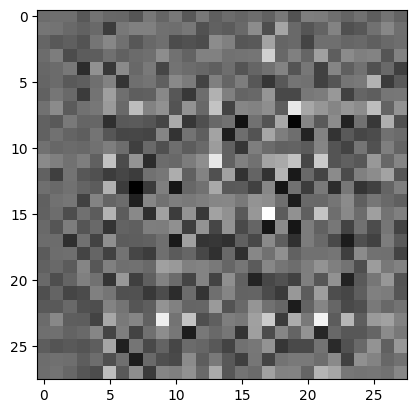

In [11]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### El Discriminador

El discriminador es un clasificador de imágenes basado en CNN.

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Utilice el discriminador (aún no entrenado) para clasificar las imágenes generadas como reales o falsas. El modelo se entrenará para dar valores positivos a las imágenes reales y negativos a las falsas.

In [13]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[8.287604e-05]], shape=(1, 1), dtype=float32)


## Definir la pérdida y los optimizadores

Definir funciones de pérdida y optimizadores para ambos modelos.


In [14]:
# Este método devuelve una función de ayuda para calcular la pérdida de entropía cruzada
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Pérdida de discriminador

Este método cuantifica la capacidad del discriminador para distinguir las imágenes reales de las falsas. Compara las predicciones del discriminador sobre imágenes reales con una matriz de 1s, y las predicciones del discriminador sobre imágenes falsas (generadas) con una matriz de 0s.

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Pérdida del generador
La pérdida del generador cuantifica su capacidad para engañar al discriminador. Intuitivamente, si el generador funciona bien, el discriminador clasificará las imágenes falsas como reales (o 1). Aquí se comparan las decisiones de los discriminadores sobre las imágenes generadas con un conjunto de 1s.

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Los optimizadores del discriminador y del generador son diferentes ya que entrenará dos redes por separado.

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Guardar puntos de control
Este notebook también muestra cómo guardar y restaurar modelos, lo que puede ser útil en caso de que se interrumpa una tarea de formación que se esté ejecutando durante mucho tiempo.

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Definir el bucle de entrenamiento


In [19]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Reutilizará esta semilla con el tiempo (por lo que es más fácil)
# para visualizar el progreso en el GIF animado)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

El bucle de entrenamiento comienza con un generador que recibe una semilla aleatoria como entrada. Esa semilla se utiliza para producir una imagen. A continuación, se utiliza el discriminador para clasificar imágenes reales (extraídas del conjunto de entrenamiento) e imágenes falsas (producidas por el generador). La pérdida se calcula para cada uno de estos modelos, y los gradientes se utilizan para actualizar el generador y el discriminador.


In [20]:
# Obsérvese el uso de `tf.function`
# Esta anotación hace que la función se "compile".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [21]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Producir imágenes para el GIF sobre la marcha
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Guardar el modelo cada 15 épocas
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generar después de la última época
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generar y guardar imágenes**


In [22]:
def generate_and_save_images(model, epoch, test_input):
  # Fíjate en que `training` está en False.
  # Esto es para que todas las capas se ejecuten en modo de inferencia (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Entrenar el modelo
Llame al método `train()` definido arriba para entrenar el generador y el discriminador simultáneamente. Tenga en cuenta que entrenar GANs puede ser complicado. Es importante que el generador y el discriminador no se dominen mutuamente (por ejemplo, que se entrenen a un ritmo similar).

Al principio del entrenamiento, las imágenes generadas parecen ruido aleatorio. A medida que avanza el entrenamiento, los dígitos generados parecen cada vez más reales. Después de unas 50 épocas, se parecen a los dígitos MNIST. Esto puede tomar alrededor de un minuto / epoch con la configuración predeterminada en Colab.


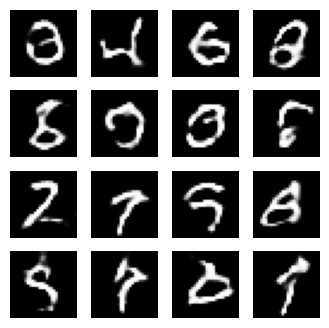

In [23]:
train(train_dataset, EPOCHS)

Restaurar el último punto de control.

In [24]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Crear un GIF


In [25]:
# Visualizar una sola imagen utilizando el número de época
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

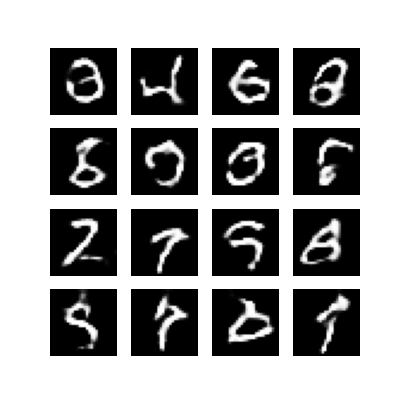

In [26]:
display_image(EPOCHS)

Utilice `imageio` para crear un gif animado utilizando las imágenes guardadas durante el entrenamiento.

In [27]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/tmp/ipython-input-1982054950.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipython-input-1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



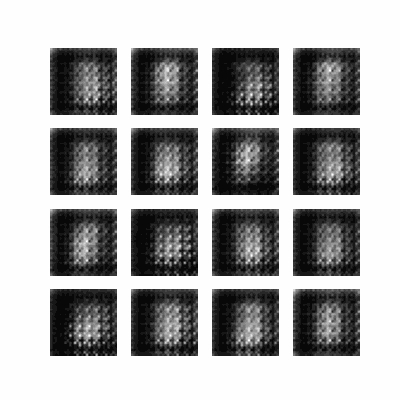

In [31]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)


## Próximos pasos


Este tutorial ha mostrado el código completo necesario para escribir y entrenar un GAN. Como siguiente paso, puedes experimentar con un conjunto de datos diferente, por ejemplo, el conjunto de datos a gran escala Celeb Faces Attributes (CelebA) [disponible en Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). Para saber más sobre las GAN, consulta el [Tutorial NIPS 2016: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
